In [1]:
from pathlib import Path
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import feather
import csv
import re
import seaborn.objects as so
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain
import configparser
import tkinter as tk
from tkinter import filedialog

# Data_Path = Path(
#     "C:\\Users\\l.boisson\\Documents\\LPG\\Manips"
# )

sns.set_theme()

In [2]:
# Create a GUI window
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

In [3]:
# Fréquence
frequence = 10

# Filtre passe-bande
fs = 1926
order = 2
low_cutoff = 20 
high_cutoff = 400
Wn = [low_cutoff,high_cutoff]
b_emg, a_emg = signal.iirfilter(2, Wn=Wn, fs=fs, btype="bandpass", ftype="butter")

In [41]:
def extract_valeur_essai(filename):

    match = re.match(r"Iso_P(\d{2})_(RC|HUB)_([A-Z]+(?:_\d{2,3})?)_(\d{2})_Rep_(\d+\.\d+)\.csv", filename)
    
    if match:
        participant = match.group(1)
        groupe = match.group(2)
        condition = match.group(3)
        essai = match.group(4)
        
        return {
            "participant": participant,
            "groupe": groupe,
            "condition": condition,
            "essai": essai
        }
    else:
        return None

def assign_emg(filename):
    match = re.match(r"(\d{3})_([A-Z]+)_([A-Z]+)_([A-Z]+(?:_\d{2,3})?)_(\d{2})", file_path)
    
    if match:
        participant = match.group(1)
        groupe = match.group(2)
        condition = match.group(3)
        contraction = match.group(4)
        essai = match.group(5)
        
        return {
            "participant": participant,
            "groupe": groupe,
            "condition": condition,
            "contraction": contraction,
            "essai": essai
        }
    else:
        return None

def extract_emg_csv(filename):
    # Vérifier quelles colonnes sont présentes dans le fichier CSV
    columns = pd.read_csv(filename, nrows=1).columns
    column_names = [col for col in columns if "EMG" in col and not re.search("filter|Acc", col)]
    # Si aucune colonne ne contient "EMG", retourner un DataFrame vide
    if len(column_names) == 0:
        return pd.DataFrame()

    # Importer les colonnes "EMG" seulement
    data_EMG = pd.read_csv(
        filename,
        index_col="X[s]",
        usecols=["X[s]"] + column_names,
    ).rename(columns=rename_channel_EMG)

    # Renommer les colonnes
    data_EMG = data_EMG.rename(
        columns={
            col: col.split(":")[0]
            for col in column_names
        }
    )
    
    # Vérifier si le DataFrame a au moins 1000 lignes avant de supprimer les dernières 1000 lignes
    if len(data_EMG) >= 1000:
        data_EMG = data_EMG.iloc[:-1000]

    # Retourner les données en enlevant les dernières 1000 lignes
    data_EMG.rename_axis("Time", inplace=True)
    
    # Remove DC offset
    data_EMG = data_EMG - data_EMG.mean(axis=0)

    return data_EMG

def rms_emg(data_emg, window):
    rms_emg = (
        data_emg.pow(2).rolling(window).mean().apply(np.sqrt, raw=True).drop(data_emg.index[:window])
    )
    return rms_emg

def rename_channel_EMG(name):
    if "TA" in name in name:
        return "TA"
    elif "PB" in name in name:
        return "PB"
    elif "PL" in name in name:
        return "PL"    
    else:
        return name
    
# Define a function to compute the mean around the maximum value of each group
def compute_mean_around_max(group_df):
    offset = 0.25
    max_index = group_df.idxmax()
    m = group_df.index[0][0]
    start_index = max_index[0] - offset
    end_index = max_index[0] + offset
    mean = group_df[(group_df.index.get_level_values(0) > start_index) & (group_df.index.get_level_values(0) < end_index)].mean()
    return mean

def drop_window(data_emg,window):
    rms_emg = (
        data_emg.drop(data_emg.index[:window])
    )
    return rms_emg

def reshape_wide2long_emg(df):
    cols_emg = ['TA' ,'PB', 'PL']

    # def reshape_wide2long(df):
    merge_emg = pd.melt(df[cols_emg], 
                        var_name='Muscle', value_name='RMS', ignore_index = False)# Separate the Muscle and Axis columns
    return pd.merge(merge_emg, on = ['Time', 'Muscle'])

def filter_column(data, b, a):
    filtered_data = signal.filtfilt(b, a, data)

    return filtered_data

def replace_outliers(x):
    # calculate the interquartile range (IQR)
    Q1 = x.quantile(0.25, numeric_only=True)
    Q3 = x.quantile(0.75, numeric_only=True)
    IQR = Q3 - Q1

    # define the outlier threshold
    outlier_threshold_up = Q3 + 1.5 * IQR
    outlier_threshold_down = Q1 - 1.5 * IQR

    # replace the outliers with NaNs
    x[x > outlier_threshold_up] = np.nan
    x[x < outlier_threshold_down] = np.nan

    return x

def coef_variation(series):
    mean = series.mean()
    std = series.std()
    if mean == 0:
        return 0
    return (std / mean) * 100

In [6]:
# df_emg_raw = extract_emg_csv('C:/Users/l.boisson/Documents/LPG/Manips/P00_test_emg_CON_60_02_Rep_1.9.csv')
# df_emg_raw.plot()

In [42]:
window = 50
df_emg_filtered_list = []

for filename in Data_Path.glob("*Rep*.csv"):
    file_path = filename.as_posix()
    file_info = extract_valeur_essai(filename.name)
    
    df_emg_raw = extract_emg_csv(filename)
    
    df_emg_filtered = df_emg_raw.apply(lambda x: filter_column(x, b_emg, a_emg), axis=0) # Applique le filtre

    df_emg_raw =  pd.melt(df_emg_filtered.apply(lambda x: drop_window(x, window=window), axis=0).assign(**file_info), 
                          var_name='Muscle',
                          value_name='emg_raw',
                          ignore_index=False
                          )

    df_emg_filtered =  pd.melt(df_emg_filtered.apply(lambda x: drop_window(x, window=window), axis=0).assign(**file_info).set_index(['participant', 'groupe', 'condition', 'essai'], append=True), 
                          var_name='Muscle',
                          value_name='emg_filtered',
                          ignore_index=False
                          )
    
    df_emg_filtered_list.append(df_emg_filtered)
    
df_emg_rms = pd.concat(df_emg_filtered_list)

df_emg_rms = df_emg_rms.reset_index()

df_emg_rms['RMS'] = df_emg_rms.groupby(['participant', 'groupe', 'condition', 'essai', 'Muscle'])['emg_filtered'].transform(lambda x: rms_emg(x, window))

df_emg_rms = df_emg_rms[['participant', 'groupe', 'condition', 'essai', 'Time', 'Muscle', 'emg_filtered', 'RMS']]

# df_emg_rms.set_index(['Time', 'participant', 'groupe', 'condition', 'contraction', 'essai', 'Muscle'], inplace = True)
    
# df_emg_rms.groupby(['Time', 'participant', 'groupe', 'condition', 'contraction', 'essai', 'Muscle'], group_keys = False)

df_emg_rms

,participant,groupe,condition,essai,Time,Muscle,emg_filtered,RMS
0,99,RC,CON_120,01,0.025962,TA,0.000004,NaN
1,99,RC,CON_120,01,0.026481,TA,0.000004,NaN
2,99,RC,CON_120,01,0.027000,TA,0.000002,NaN
3,99,RC,CON_120,01,0.027519,TA,0.000001,NaN
4,99,RC,CON_120,01,0.028038,TA,0.000001,NaN
...,...,...,...,...,...,...,...,...
2370271,99,RC,INV,02,44.932670,PL,0.000007,0.000011
2370272,99,RC,INV,02,44.933190,PL,0.000007,0.000010
2370273,99,RC,INV,02,44.933710,PL,0.000006,0.000010
2370274,99,RC,INV,02,44.934230,PL,0.000004,0.000010


## Max RMS pour chaque muscle de chaque contraction

In [43]:
max_rms_per_group = df_emg_rms.groupby(['participant', 'groupe', 'condition', 'Muscle'])['RMS'].max()

max_rms_df = max_rms_per_group.reset_index()

max_rms_df

,participant,groupe,condition,Muscle,RMS
0,99,RC,CON_120,PB,0.001685
1,99,RC,CON_120,PL,0.003189
2,99,RC,CON_120,TA,0.000383
3,99,RC,CON_60,PB,0.000400
4,99,RC,CON_60,PL,0.000472
5,99,RC,CON_60,TA,0.000274
6,99,RC,EV,PB,0.000177
7,99,RC,EV,PL,0.000305
8,99,RC,EV,TA,0.000265
9,99,RC,EXC,PB,0.000251


## Plot EMG et RMS

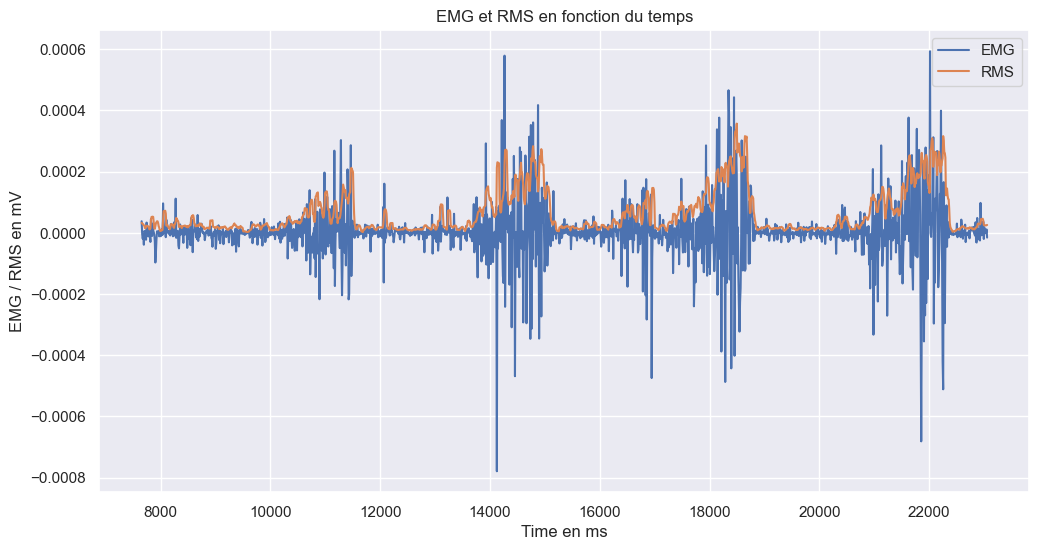

In [47]:
subsample_factor = 10

plt.figure(figsize=(12, 6))

data_con_120 = df_emg_rms[(df_emg_rms['condition'] == 'CON_120') & (df_emg_rms['Muscle'] == 'TA') & (df_emg_rms['Time'] > 4) & (df_emg_rms['Time'] < 12) & (df_emg_rms['essai'] == '01')]

plt.plot(data_con_120.index[::subsample_factor], data_con_120['emg_filtered'][::subsample_factor], label='EMG')

plt.plot(data_con_120.index[::subsample_factor], data_con_120['RMS'][::subsample_factor], label='RMS')

plt.xlabel('Time en ms')
plt.ylabel('EMG / RMS en mV')
plt.title('EMG et RMS en fonction du temps')
plt.legend()
plt.show()

In [68]:
df_emg_rms.condition.unique()

array(['CON_120', 'CON_60', 'EV', 'EXC', 'INV'], dtype=object)

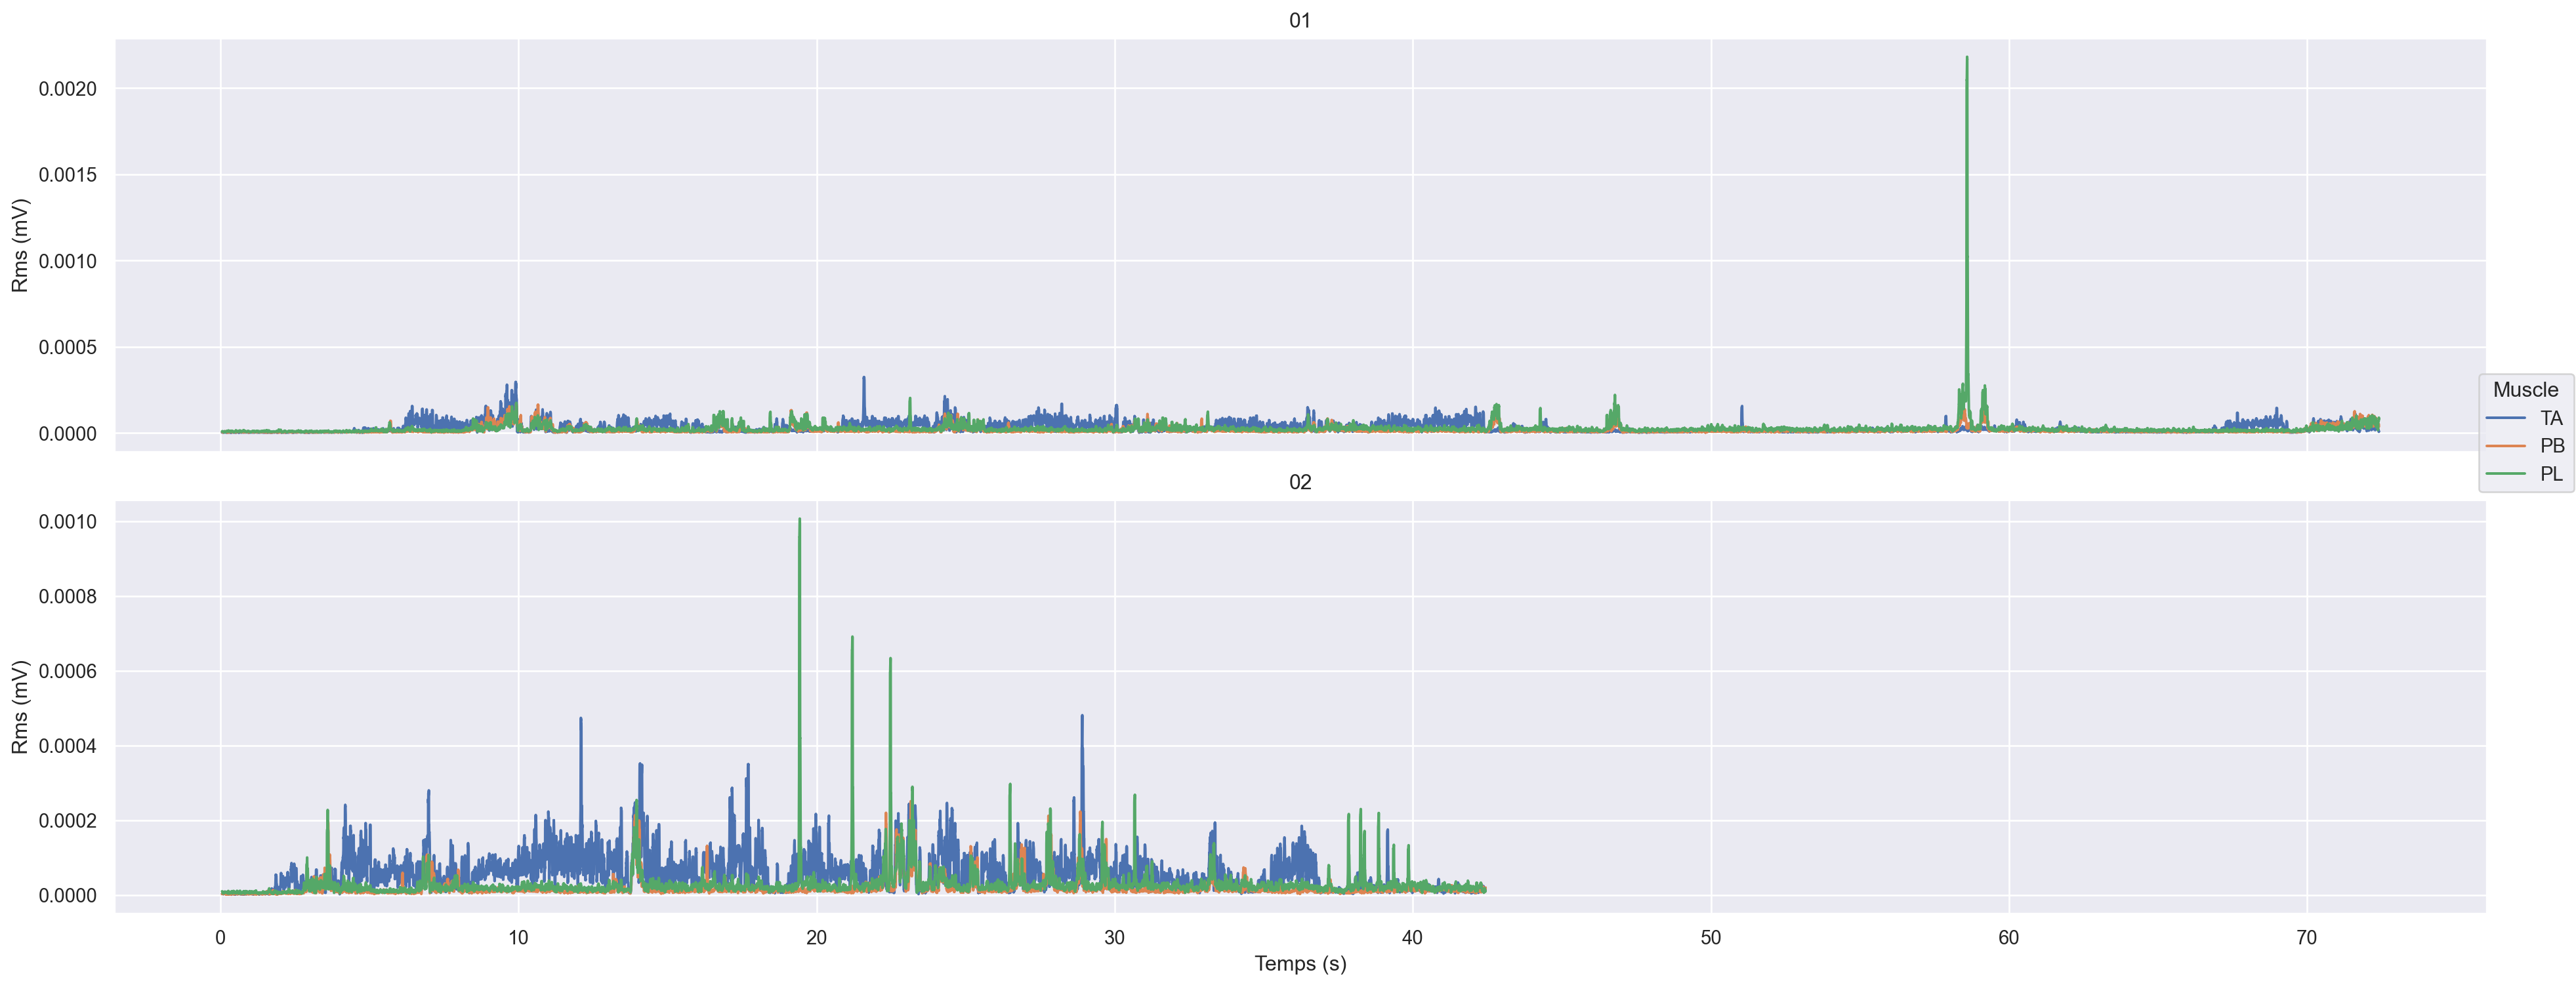

In [70]:
(   so.Plot(df_emg_rms[(df_emg_rms['condition'] == 'EXC')],
            x = 'Time',
            y = 'RMS',
            color = 'Muscle'
            )
    .add(so.Line())
    .facet(row = 'essai')
    .share(y=False)
    .label(
        x='Temps (s)', y = 'Rms (mV)',
        color=str.capitalize
        )
    # .theme({**axes_style("white"), "grid.linestyle": ":"})
    .layout(size=(20, 8))
)